In [1]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Define a transform to convert the images to tensors and normalize them
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

# Download and load the training dataset
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

# Download and load the test dataset
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=1000, shuffle=False)

print("✅ MNIST data downloaded and ready to use!")


C:\Users\muham\anaconda3\envs\thesis_env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


✅ MNIST data downloaded and ready to use!


## Fashion-mnist

In [3]:
# ===============================================
# 🔹 Chunk 1: Setup & Data Preparation
# ===============================================
import torch
from torchvision import datasets, transforms
from torch.utils.data import Subset, DataLoader
from torch import nn, optim
import numpy as np
import random
from collections import defaultdict

# CHOOSE 5 FASHION CATEGORIES
# Labels: 0:T-shirt/top, 1:Trouser, 2:Pullover, 3:Dress, 4:Coat,
#         5:Sandal, 6:Shirt, 7:Sneaker, 8:Bag, 9:Ankle boot
fixed_digits = [0, 2, 4, 6, 8]

# Settings
samples_per_classifier = 1500
n_classifiers = 100
epochs = 3

# Transform
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load Fashion-MNIST
train_full = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
test_full = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

# Filter and remap
def filter_dataset_by_classes(dataset, class_list):
    indices = [i for i, (img, label) in enumerate(dataset) if label in class_list]
    return Subset(dataset, indices)

def remap_labels(dataset, label_map):
    return [(img, label_map[label]) for img, label in dataset]

label_map = {label: i for i, label in enumerate(fixed_digits)}
filtered_train = filter_dataset_by_classes(train_full, fixed_digits)
filtered_test = filter_dataset_by_classes(test_full, fixed_digits)
filtered_train_remapped = remap_labels(filtered_train, label_map)
filtered_test_remapped = remap_labels(filtered_test, label_map)

# Index by class
class_to_indices = defaultdict(list)
for i, (img, label) in enumerate(filtered_train_remapped):
    class_to_indices[label].append(i)


In [4]:
# ===============================================
# 🔹 Chunk 2: Data Sampling Strategy
# ===============================================
def generate_mixed_class_counts(total_samples, num_classes):
    strategy = random.choices(['uniform', 'mild_bias', 'extreme_bias'], weights=[0.3, 0.4, 0.3], k=1)[0]
    if strategy == 'uniform':
        return [total_samples // num_classes] * num_classes
    elif strategy == 'mild_bias':
        base = [int(0.15 * total_samples)] * num_classes
        remaining = total_samples - sum(base)
        extra = np.random.multinomial(remaining, [1 / num_classes] * num_classes)
        return [base[i] + extra[i] for i in range(num_classes)]
    elif strategy == 'extreme_bias':
        dominant_classes = random.sample(range(num_classes), k=random.randint(1, 2))
        dominant_ratio = random.uniform(0.6, 0.9)
        dominant_total = int(total_samples * dominant_ratio)
        remaining = total_samples - dominant_total
        dom_alloc = np.random.multinomial(dominant_total, [1 / len(dominant_classes)] * len(dominant_classes))
        non_dom_classes = [i for i in range(num_classes) if i not in dominant_classes]
        non_dom_alloc = (
            np.random.multinomial(remaining, [1 / len(non_dom_classes)] * len(non_dom_classes))
            if non_dom_classes else []
        )
        class_counts = [0] * num_classes
        for i, cls in enumerate(dominant_classes):
            class_counts[cls] = dom_alloc[i]
        for i, cls in enumerate(non_dom_classes):
            class_counts[cls] = non_dom_alloc[i]
        return class_counts


In [4]:
# ===============================================
# 🔹 Chunk 3: Model Definition & Training
# ===============================================
import torch.nn.functional as F

class WeakMLP(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.net = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28*28, 64),
            nn.Tanh(),
            nn.Linear(64, num_classes)
        )

    def forward(self, x):
        logits = self.net(x)
        return F.softmax(logits, dim=1)

def train_classifier(data, num_classes, epochs=3):
    model = WeakMLP(num_classes)
    optimizer = optim.Adam(model.parameters())
    criterion = nn.CrossEntropyLoss()
    loader = DataLoader(data, batch_size=64, shuffle=True)

    model.train()
    for _ in range(epochs):
        for images, labels in loader:
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
    return model


In [5]:
# ===============================================
# 🔹 Chunk 4: Training Classifier Ensemble
# ===============================================
all_classifiers = []

for i in range(n_classifiers):
    class_counts = generate_mixed_class_counts(samples_per_classifier, len(fixed_digits))
    indices = []
    for label, count in enumerate(class_counts):
        chosen = random.sample(class_to_indices[label], count)
        indices.extend(chosen)
    subset = [filtered_train_remapped[j] for j in indices]
    model = train_classifier(subset, num_classes=len(fixed_digits), epochs=epochs)
    all_classifiers.append((model, class_counts))

print("✅ 100 Fashion-MNIST classifiers trained!")


✅ 100 Fashion-MNIST classifiers trained!


In [6]:
print("\n🧾 Class distribution used to train each classifier:")
print(f"{'Classifier':<12}" + "".join(f"{fixed_digits[i]:<10}" for i in range(len(fixed_digits))))

for i, (_, class_counts) in enumerate(all_classifiers):
    print(f"{i:<12}" + "".join(f"{count:<10}" for count in class_counts))



🧾 Class distribution used to train each classifier:
Classifier  0         2         4         6         8         
0           287       304       308       293       308       
1           124       577       105       117       577       
2           300       300       300       300       300       
3           300       300       300       300       300       
4           296       299       286       316       303       
5           300       300       300       300       300       
6           296       300       300       299       305       
7           87        76        617       87        633       
8           302       299       293       295       311       
9           300       300       300       300       300       
10          300       300       300       300       300       
11          296       301       288       310       305       
12          299       297       292       311       301       
13          300       298       294       309       299       
14

In [11]:
# ===============================================
# 🔹 Chunk 5: Evaluation & Results
# ===============================================
def evaluate_per_class_accuracy(model, test_data, num_classes):
    model.eval()
    loader = DataLoader(test_data, batch_size=512, shuffle=False)
    correct = [0] * num_classes
    total = [0] * num_classes

    with torch.no_grad():
        for images, labels in loader:
            outputs = model(images)
            preds = outputs.argmax(dim=1)
            for i in range(len(labels)):
                label = labels[i].item()
                if preds[i].item() == label:
                    correct[label] += 1
                total[label] += 1

    return [round(correct[i] / total[i], 4) if total[i] > 0 else 0.0 for i in range(num_classes)]

# Build accuracy table
accuracy_table = []
for model, _ in all_classifiers:
    accs = evaluate_per_class_accuracy(model, filtered_test_remapped, len(fixed_digits))
    accuracy_table.append(accs)

# Print results
print(f"\n{'Classifier':<12}" + "".join(f"{fixed_digits[i]:<10}" for i in range(len(fixed_digits))))
for i, row in enumerate(accuracy_table):
    print(f"{i:<12}" + "".join(f"{acc:<10}" for acc in row))



Classifier  0         2         4         6         8         
0           0.828     0.627     0.854     0.415     0.939     
1           0.839     0.901     0.365     0.204     0.969     
2           0.876     0.721     0.796     0.322     0.95      
3           0.847     0.639     0.719     0.561     0.953     
4           0.911     0.584     0.786     0.438     0.941     
5           0.829     0.729     0.494     0.554     0.954     
6           0.743     0.625     0.665     0.563     0.949     
7           0.831     0.221     0.961     0.115     0.98      
8           0.783     0.729     0.558     0.592     0.954     
9           0.887     0.747     0.741     0.339     0.949     
10          0.883     0.756     0.678     0.427     0.951     
11          0.8       0.752     0.636     0.581     0.94      
12          0.887     0.637     0.563     0.572     0.934     
13          0.899     0.61      0.847     0.386     0.93      
14          0.921     0.671     0.845     0.238     0.

# collect softmax predictions for the algorithm

In [10]:
# ===============================================
# 🔹 Collect Softmax Predictions for NAN
# ===============================================
from torch.utils.data import DataLoader
import torch

# Prepare test images only (no labels needed)
test_images = [img for img, _ in filtered_test_remapped]
test_loader = DataLoader(test_images, batch_size=512, shuffle=False)

# Set dimensions
n_samples = len(filtered_test_remapped)
n_classifiers = len(all_classifiers)
num_classes = len(fixed_digits)

# Tensor to hold softmax predictions: shape (n_samples, n_classifiers, num_classes)
softmax_preds = torch.zeros(n_samples, n_classifiers, num_classes)

# Collect softmax vectors from each classifier
for c_idx, (model, _) in enumerate(all_classifiers):
    model.eval()
    preds = []

    with torch.no_grad():
        for batch in test_loader:
            outputs = model(batch)  # already returns softmax probabilities
            preds.append(outputs.cpu())  # shape: [batch_size, num_classes]

    all_preds = torch.cat(preds, dim=0)  # shape: [n_samples, num_classes]
    softmax_preds[:, c_idx, :] = all_preds

print("✅ Collected softmax predictions from all classifiers (for NAN)")



✅ Collected softmax predictions from all classifiers (for NAN)


In [15]:
print("\n🔍 Sample softmax predictions [Sample m, Classifier i]:\n")

for m in range(2):  # First 2 samples
    for i in range(3):  # First 3 classifiers
        probs = softmax_preds[m, i, :].numpy()
        formatted = ", ".join(f"{p:.4f}" for p in probs)
        print(f"Sample {m}, Classifier {i}: [{formatted}]")



🔍 Sample softmax predictions [Sample m, Classifier i]:

Sample 0, Classifier 0: [-1.8627, 2.9021, 0.2832, 0.3605, -1.8510]
Sample 0, Classifier 1: [-2.2691, 3.3197, 0.0290, -0.0347, -0.5774]
Sample 0, Classifier 2: [-1.4910, 3.0320, 0.5255, -0.5898, -0.7972]
Sample 1, Classifier 0: [0.4857, 0.9926, -0.8253, 2.1909, -1.3373]
Sample 1, Classifier 1: [-0.2831, 1.7444, -1.1147, 1.6067, -0.8937]
Sample 1, Classifier 2: [0.3814, 0.9374, -1.7095, 1.6020, -1.7287]


# Embedd softmax predictions

In [16]:
import torch.nn as nn

# Parameters
embed_dim = 32
num_classes = softmax_preds.shape[2]  # Should be 5

# Define embedding layer
embedding_layer = nn.Linear(num_classes, embed_dim)

# Apply embedding layer to softmax predictions
# Input: (n_samples, n_classifiers, num_classes)
# Output: (n_samples, n_classifiers, embed_dim)
embedded_preds = embedding_layer(softmax_preds)

print(f"✅ Embedded softmax predictions → shape: {embedded_preds.shape}")

# Optional: Print a few embeddings
for m in range(2):  # First 2 samples
    for i in range(2):  # First 2 classifiers
        vec = embedded_preds[m, i].detach().numpy()
        formatted = ", ".join(f"{v:.4f}" for v in vec[:8])  # Print first 8 dimensions
        print(f"Embedding for Sample {m}, Classifier {i}: [{formatted} ...]")


✅ Embedded softmax predictions → shape: torch.Size([5000, 100, 32])
Embedding for Sample 0, Classifier 0: [0.7228, 0.6493, -0.6836, 0.0893, -1.0951, -1.1194, -2.0092, 2.1849 ...]
Embedding for Sample 0, Classifier 1: [0.2538, 0.1872, -0.4915, 0.0053, -1.0987, -0.7491, -1.6506, 1.8604 ...]
Embedding for Sample 1, Classifier 0: [-0.1979, 1.5806, -0.5251, -1.1603, 0.0018, -0.2522, -0.6715, 1.4789 ...]
Embedding for Sample 1, Classifier 1: [-0.3529, 1.2722, -0.6208, -0.9316, -0.4205, -0.3077, -0.7551, 1.4406 ...]


# Baseline - Average Pairwise

In [20]:
pred_matrix = softmax_preds.argmax(dim=2).T.numpy()
n_classifiers, n_samples = pred_matrix.shape
estimated_accuracies = []
for i in range(n_classifiers):
    others = np.delete(pred_matrix, i, axis=0)  # shape: (n_classifiers - 1, n_samples)
    target = pred_matrix[i]  # shape: (n_samples,)
    
    # Agreement with each of the other classifiers
    agreement = (others == target).mean(axis=0)  # shape: (n_samples,)
    estimated_accuracy = agreement.mean()
    estimated_accuracies.append(estimated_accuracy)

# Print first few estimates
for i, acc in enumerate(estimated_accuracies[:10]):
    print(f"Estimated accuracy of Classifier {i}: {acc:.4f}")


Estimated accuracy of Classifier 0: 0.7969
Estimated accuracy of Classifier 1: 0.6953
Estimated accuracy of Classifier 2: 0.7967
Estimated accuracy of Classifier 3: 0.8115
Estimated accuracy of Classifier 4: 0.8050
Estimated accuracy of Classifier 5: 0.7700
Estimated accuracy of Classifier 6: 0.7843
Estimated accuracy of Classifier 7: 0.6621
Estimated accuracy of Classifier 8: 0.7845
Estimated accuracy of Classifier 9: 0.7967


In [22]:
def evaluate_overall_accuracy(model, test_data):
    model.eval()
    loader = DataLoader(test_data, batch_size=512, shuffle=False)
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in loader:
            outputs = model(images)  # softmax probabilities
            preds = outputs.argmax(dim=1)  # predicted class
            correct += (preds == labels).sum().item()
            total += len(labels)

    return round(correct / total, 4)


In [23]:
# Compute overall accuracy per classifier
true_accuracies = [
    evaluate_overall_accuracy(model, filtered_test_remapped)
    for model, _ in all_classifiers
]


In [24]:
print(f"{'Classifier':<12} {'True Accuracy':<15} {'Estimated Accuracy':<20}")
print("-" * 50)

for i in range(len(true_accuracies)):
    print(f"{i:<12} {true_accuracies[i]:<15.4f} {estimated_accuracies[i]:<20.4f}")


Classifier   True Accuracy   Estimated Accuracy  
--------------------------------------------------
0            0.7326          0.7969              
1            0.6556          0.6953              
2            0.7330          0.7967              
3            0.7438          0.8115              
4            0.7320          0.8050              
5            0.7120          0.7700              
6            0.7090          0.7843              
7            0.6216          0.6621              
8            0.7232          0.7845              
9            0.7326          0.7967              
10           0.7390          0.8037              
11           0.7418          0.7934              
12           0.7186          0.7896              
13           0.7344          0.8042              
14           0.7230          0.7845              
15           0.7382          0.8030              
16           0.7380          0.8094              
17           0.7336          0.8075              

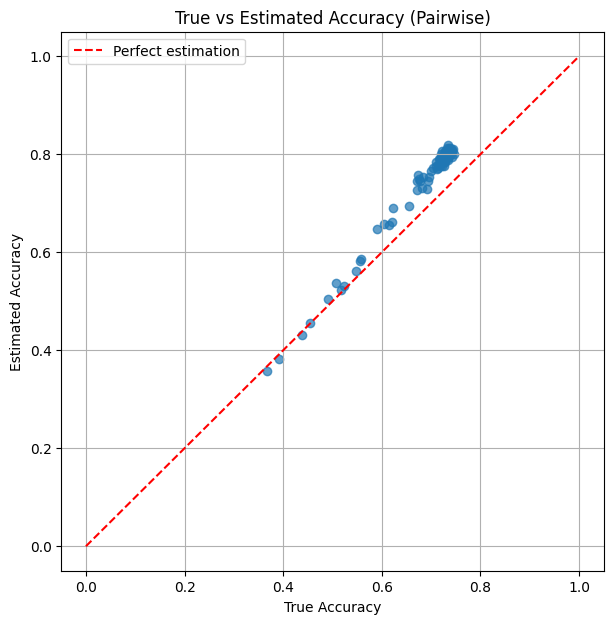

In [25]:
import matplotlib.pyplot as plt

# Make sure you already have:
# - true_accuracies = [...]
# - estimated_accuracies = [...]

plt.figure(figsize=(7,7))
plt.scatter(true_accuracies, estimated_accuracies, alpha=0.7)
plt.plot([0, 1], [0, 1], 'r--', label='Perfect estimation')  # diagonal line
plt.xlabel("True Accuracy")
plt.ylabel("Estimated Accuracy")
plt.title("True vs Estimated Accuracy (Pairwise)")
plt.legend()
plt.grid(True)
plt.show()


In [26]:
from sklearn.metrics import mean_absolute_error

mae = mean_absolute_error(true_accuracies, estimated_accuracies)
print(f"Mean Absolute Error (MAE): {mae:.4f}")


Mean Absolute Error (MAE): 0.0599


# EM Algorithm

In [38]:
# Settings
n_classifiers, n_samples = pred_matrix.shape
num_classes = len(fixed_digits)
max_iters = 20

# Initialize label probabilities uniformly
label_probs = np.full((n_samples, num_classes), 1 / num_classes)

# ✅ Initialize classifier accuracies using pairwise estimates
acc_estimates = np.array(estimated_accuracies)  # from pairwise agreement

# EM loop
for iteration in range(max_iters):
    # === E-step: estimate P(y_m = k) for each sample m and class k ===
    new_label_probs = np.ones((n_samples, num_classes))

    for k in range(num_classes):
        for i in range(n_classifiers):
            predictions = pred_matrix[i]
            agree = (predictions == k)
            disagree = ~agree

            new_label_probs[:, k] *= (
                acc_estimates[i] * agree +
                (1 - acc_estimates[i]) / (num_classes - 1) * disagree
            )

    # Normalize
    label_probs = new_label_probs / new_label_probs.sum(axis=1, keepdims=True)

    # === M-step: update accuracy estimates ===
    for i in range(n_classifiers):
        predictions = pred_matrix[i]
        acc_estimates[i] = np.mean(label_probs[np.arange(n_samples), predictions])

    print(f"Iteration {iteration+1} | Mean accuracy: {acc_estimates.mean():.4f}")


Iteration 1 | Mean accuracy: 0.8324
Iteration 2 | Mean accuracy: 0.8323
Iteration 3 | Mean accuracy: 0.8323
Iteration 4 | Mean accuracy: 0.8323
Iteration 5 | Mean accuracy: 0.8323
Iteration 6 | Mean accuracy: 0.8323
Iteration 7 | Mean accuracy: 0.8323
Iteration 8 | Mean accuracy: 0.8323
Iteration 9 | Mean accuracy: 0.8323
Iteration 10 | Mean accuracy: 0.8323
Iteration 11 | Mean accuracy: 0.8323
Iteration 12 | Mean accuracy: 0.8323
Iteration 13 | Mean accuracy: 0.8323
Iteration 14 | Mean accuracy: 0.8323
Iteration 15 | Mean accuracy: 0.8323
Iteration 16 | Mean accuracy: 0.8323
Iteration 17 | Mean accuracy: 0.8323
Iteration 18 | Mean accuracy: 0.8323
Iteration 19 | Mean accuracy: 0.8323
Iteration 20 | Mean accuracy: 0.8323


In [39]:
# Compare to true accuracies
print(f"\n{'Classifier':<12} {'True Accuracy':<15} {'EM (Pairwise Init)':<20}")
print("-" * 50)
for i in range(n_classifiers):
    print(f"{i:<12} {true_accuracies[i]:<15.4f} {acc_estimates[i]:<20.4f}")



Classifier   True Accuracy   EM (Pairwise Init)  
--------------------------------------------------
0            0.7326          0.8942              
1            0.6556          0.7499              
2            0.7330          0.8954              
3            0.7438          0.9199              
4            0.7320          0.9106              
5            0.7120          0.8486              
6            0.7090          0.8730              
7            0.6216          0.7109              
8            0.7232          0.8704              
9            0.7326          0.8966              
10           0.7390          0.9059              
11           0.7418          0.8813              
12           0.7186          0.8743              
13           0.7344          0.9079              
14           0.7230          0.8734              
15           0.7382          0.9061              
16           0.7380          0.9201              
17           0.7336          0.9159             

In [40]:
# Step 1: Initial soft trust scores from pairwise agreement
trust_scores = np.array(estimated_accuracies)  # shape: (n_classifiers,)

# Step 2: Uniform label probabilities
label_probs = np.full((n_samples, num_classes), 1 / num_classes)

# EM loop
max_iters = 20
for iteration in range(max_iters):
    # === E-step: estimate label probabilities via weighted voting ===
    label_probs = np.zeros((n_samples, num_classes))

    for i in range(n_classifiers):
        preds = pred_matrix[i]  # shape: (n_samples,)
        label_probs[np.arange(n_samples), preds] += trust_scores[i]

    # Normalize to turn into probabilities
    label_probs /= label_probs.sum(axis=1, keepdims=True)

    # === M-step: update trust scores based on agreement with posteriors ===
    for i in range(n_classifiers):
        preds = pred_matrix[i]
        trust_scores[i] = np.mean(label_probs[np.arange(n_samples), preds])

    print(f"Iteration {iteration + 1} | Mean trust: {trust_scores.mean():.4f}")


Iteration 1 | Mean trust: 0.7662
Iteration 2 | Mean trust: 0.7665
Iteration 3 | Mean trust: 0.7666
Iteration 4 | Mean trust: 0.7666
Iteration 5 | Mean trust: 0.7666
Iteration 6 | Mean trust: 0.7666
Iteration 7 | Mean trust: 0.7666
Iteration 8 | Mean trust: 0.7666
Iteration 9 | Mean trust: 0.7666
Iteration 10 | Mean trust: 0.7666
Iteration 11 | Mean trust: 0.7666
Iteration 12 | Mean trust: 0.7666
Iteration 13 | Mean trust: 0.7666
Iteration 14 | Mean trust: 0.7666
Iteration 15 | Mean trust: 0.7666
Iteration 16 | Mean trust: 0.7666
Iteration 17 | Mean trust: 0.7666
Iteration 18 | Mean trust: 0.7666
Iteration 19 | Mean trust: 0.7666
Iteration 20 | Mean trust: 0.7666


In [42]:
estimated_accuracies_soft_em = trust_scores.copy()


In [43]:
print(f"\n{'Classifier':<12} {'True Accuracy':<15} {'Soft Agreement EM':<20}")
print("-" * 50)
for i in range(n_classifiers):
    print(f"{i:<12} {true_accuracies[i]:<15.4f} {estimated_accuracies_soft_em[i]:<20.4f}")



Classifier   True Accuracy   Soft Agreement EM   
--------------------------------------------------
0            0.7326          0.8155              
1            0.6556          0.7114              
2            0.7330          0.8160              
3            0.7438          0.8291              
4            0.7320          0.8234              
5            0.7120          0.7857              
6            0.7090          0.8001              
7            0.6216          0.6772              
8            0.7232          0.8008              
9            0.7326          0.8161              
10           0.7390          0.8226              
11           0.7418          0.8104              
12           0.7186          0.8057              
13           0.7344          0.8233              
14           0.7230          0.8039              
15           0.7382          0.8218              
16           0.7380          0.8285              
17           0.7336          0.8259             

MAE (Soft Agreement EM): 0.0763


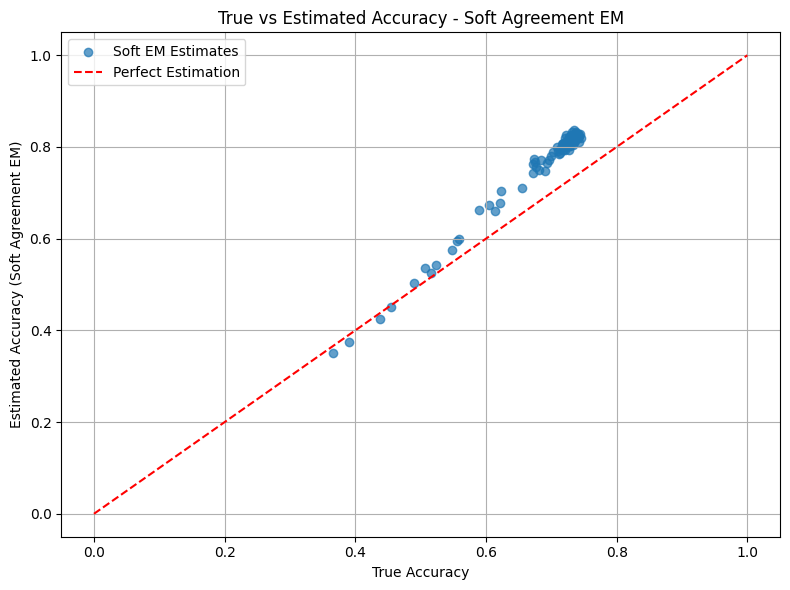

In [44]:
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt

# ✅ Calculate MAE
mae_soft_em = mean_absolute_error(true_accuracies, estimated_accuracies_soft_em)
print(f"MAE (Soft Agreement EM): {mae_soft_em:.4f}")

# ✅ Plot
plt.figure(figsize=(8, 6))
plt.scatter(true_accuracies, estimated_accuracies_soft_em, alpha=0.7, label="Soft EM Estimates")
plt.plot([0, 1], [0, 1], 'r--', label="Perfect Estimation")
plt.xlabel("True Accuracy")
plt.ylabel("Estimated Accuracy (Soft Agreement EM)")
plt.title("True vs Estimated Accuracy - Soft Agreement EM")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [60]:
import torch
import numpy as np
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt

# Step 0: Setup
n_samples, n_classifiers, num_classes = softmax_preds.shape

# Step 1: Initial trust scores from average pairwise agreement
pred_matrix = softmax_preds.argmax(dim=2).T.numpy()  # [n_classifiers, n_samples]
trust_scores = []

for i in range(n_classifiers):
    others = np.delete(pred_matrix, i, axis=0)
    agreement = (others == pred_matrix[i]).mean(axis=0)
    trust_scores.append(agreement.mean())

trust_scores = np.array(trust_scores)
trust_scores /= trust_scores.sum()  # normalize to sum = 1

# Step 2: Iterative Refinement (Hybrid EM)
softmax_np = softmax_preds.numpy()  # [n_samples, n_classifiers, num_classes]
trust_scores_tensor = torch.tensor(trust_scores, dtype=torch.float32)

max_iters = 10
for _ in range(max_iters):
    # E-step: compute consensus soft label per sample
    weighted = softmax_preds * trust_scores_tensor[None, :, None]  # [samples, classifiers, classes]
    consensus = weighted.sum(dim=1)  # [samples, classes]
    consensus_probs = consensus / consensus.sum(dim=1, keepdim=True)  # normalize

    # M-step: update trust scores based on agreement with consensus
    pred_labels = softmax_preds.argmax(dim=2)

# Expand consensus_probs to [samples, classifiers, classes]
    consensus_expanded = consensus_probs.unsqueeze(1).expand(-1, n_classifiers, -1)

# Gather consensus probabilities for each classifier's predicted label
    pred_probs = torch.gather(consensus_expanded, 2, pred_labels.unsqueeze(2)).squeeze(2)  # [samples, classifiers]  # [samples, classifiers]
    trust_scores_tensor = pred_probs.mean(dim=0)
    trust_scores_tensor /= trust_scores_tensor.sum()  # normalize again

# Final accuracy estimate per classifier
estimated_accuracy_hybrid = trust_scores_tensor.numpy()



In [71]:
import numpy as np

def dawid_skene(softmax_preds, max_iters=20):
    # Assume softmax_preds has shape [n_samples, n_classifiers, num_classes]
    n_samples, n_classifiers, num_classes = softmax_preds.shape
    
    # Initialize true label probabilities using average (or majority vote)
    # For simplicity, start with the average of softmax predictions
    true_label_probs = softmax_preds.mean(axis=1)  # shape: [n_samples, num_classes]

    # Initialize confusion matrices for each classifier.
    # For each classifier c, confusion[c] is a [num_classes, num_classes] matrix.
    # A good starting point is to assume near-diagonal confusion.
    confusion = np.array([np.eye(num_classes) for _ in range(n_classifiers)])

    for iteration in range(max_iters):
        # E-Step: Estimate true label probabilities for each sample.
        for i in range(n_samples):
            # For each class, combine likelihoods from all classifiers.
            likelihood = np.ones(num_classes)
            for c in range(n_classifiers):
                # Use the classifier's softmax prediction and its confusion matrix.
                # Here, we assume that softmax_preds[i, c, :] approximates P(classifier c outputs | true class)
                likelihood *= (softmax_preds[i, c, :] @ confusion[c].T)
            true_label_probs[i] = likelihood / likelihood.sum()

        # M-Step: Update confusion matrices based on current estimates.
        for c in range(n_classifiers):
            # Update confusion matrix for classifier c.
            # For each true class i and observed prediction j:
            for i in range(num_classes):
                for j in range(num_classes):
                    # Sum the probability that sample i truly belongs to class i and classifier c predicted j.
                    # This is a weighted average over samples.
                    # (You might want to add a smoothing factor in practice.)
                    confusion[c][i, j] = np.sum(true_label_probs[:, i] * softmax_preds[:, c, j])
                # Normalize so that each row sums to 1.
                confusion[c][i, :] /= (confusion[c][i, :].sum() + 1e-8)
    
    # Compute accuracy for each classifier as the average of the diagonal of its confusion matrix.
    accuracies = np.array([np.diag(confusion[c]).mean() for c in range(n_classifiers)])
    return accuracies

# Example usage:
# estimated_accuracies = dawid_skene(softmax_preds)


   



MAE (Dawid-Skene Style): 7.6364


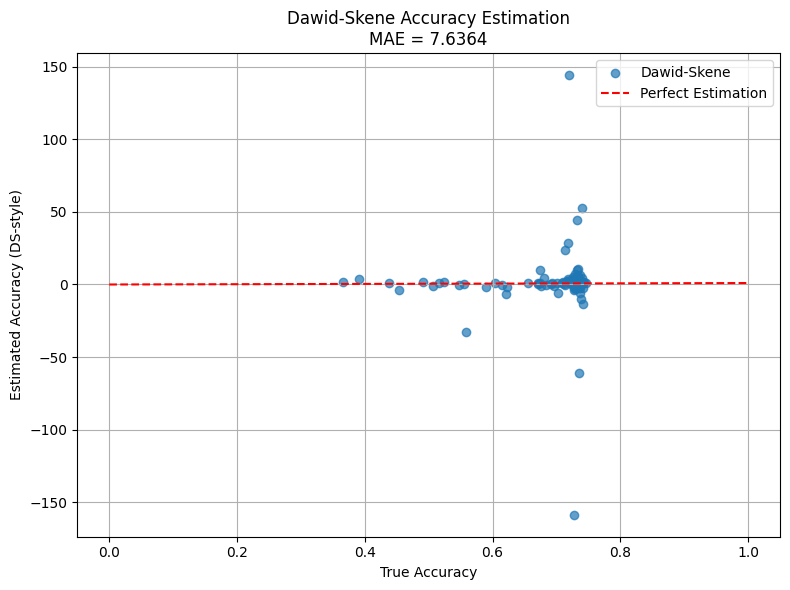

In [72]:
# Run the Dawid-Skene style algorithm
estimated_accuracy_ds = dawid_skene(softmax_preds.numpy(), max_iters=20)

# Compare to true accuracy
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt

mae_ds = mean_absolute_error(true_accuracies, estimated_accuracy_ds)
print(f"MAE (Dawid-Skene Style): {mae_ds:.4f}")

# Plotting
plt.figure(figsize=(8, 6))
plt.scatter(true_accuracies, estimated_accuracy_ds, alpha=0.7, label="Dawid-Skene")
plt.plot([0, 1], [0, 1], 'r--', label="Perfect Estimation")
plt.xlabel("True Accuracy")
plt.ylabel("Estimated Accuracy (DS-style)")
plt.title(f"Dawid-Skene Accuracy Estimation\nMAE = {mae_ds:.4f}")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
